# Experimento de Franck-Hertz

In [246]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [247]:
sns.set_theme()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 120

Dados

In [248]:
data = {}

for file in os.listdir('dados'):
	if file not in ['checkpoints', '.ipynb_checkpoints']:
		T, Vr = file.split('_')[1:3]

		T = int(T)
		Vr = float( int(Vr.split('.')[0]) / 100 )

		if T not in data: data[T] = {}
		if Vr not in data[T]: data[T][Vr] = { 'Tensão (V)': [], 'Corrente (A)': [], 'Temperatura (°C)': [] }

		load_data = np.loadtxt(f'dados/{file}').transpose()
		data[T][Vr]['Tensão (V)'] = load_data[0]
		data[T][Vr]['Corrente (A)'] = load_data[1]
		data[T][Vr]['Temperatura (°C)'] = load_data[2]

		data[T][Vr] = pd.DataFrame(data[T][Vr])

In [249]:
peaks = {}

for i,T in enumerate(data.keys()):
  peaks[T] = {}

## Determinação dos picos de corrente

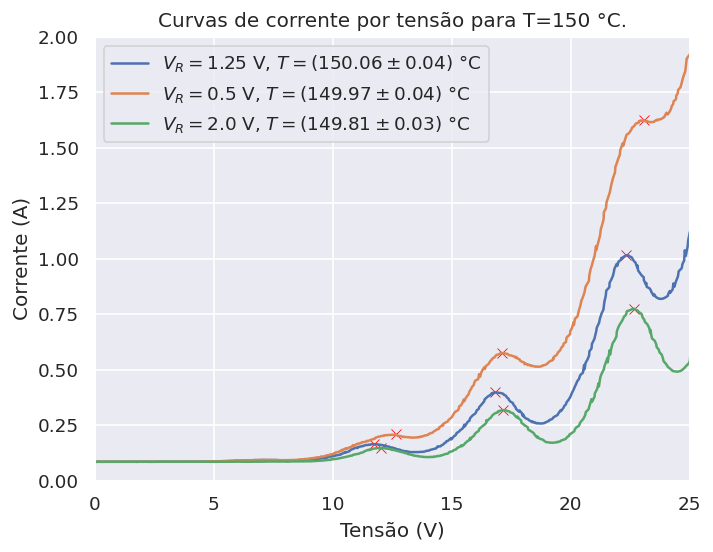

In [250]:
T = 150
plt.title(f'Curvas de corrente por tensão para T={T} °C.')

for i,Vr in enumerate(data[T].keys()):
  df = data[T][Vr]

  Tm, Ts = df["Temperatura (°C)"].mean(), df["Temperatura (°C)"].std() / np.sqrt(df.shape[0])
  sns.lineplot(data=df, x='Tensão (V)', y='Corrente (A)', label=f'$V_R={Vr}$ V, $T=({Tm:.2f}\\pm{Ts:.2f})$ °C')

  _peaks, props = find_peaks(df['Corrente (A)'], distance=40, prominence=(0.005, 5))
  peaks[T][Vr] = np.array(_peaks)

  sns.scatterplot(x=df['Tensão (V)'][_peaks], y=df['Corrente (A)'][_peaks], color='red', marker='x')

plt.ylim(0, 2)
plt.xlim(0, 25)

plt.savefig(f'plots/current_curves_{T}.png', dpi=300, bbox_inches='tight')
plt.show()

In [251]:
peaks[150]

{1.25: array([197, 292, 396]),
 0.5: array([216, 300, 412]),
 2.0: array([201, 297, 399])}

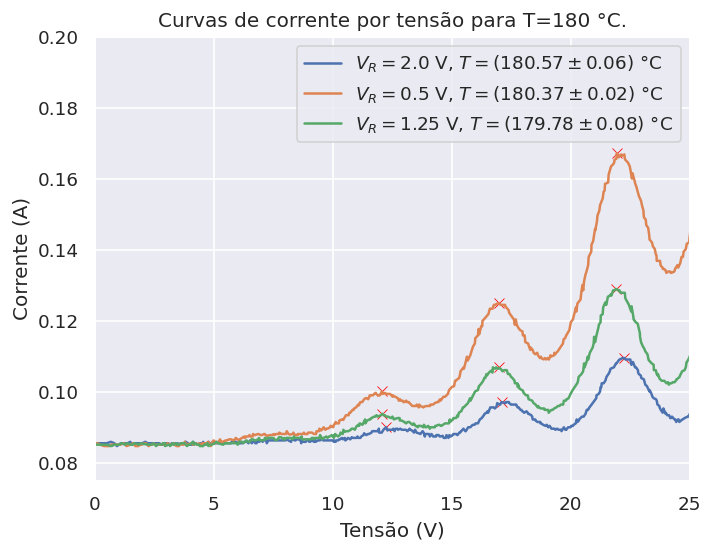

In [252]:
T = 180
plt.title(f'Curvas de corrente por tensão para T={T} °C.')

for i,Vr in enumerate(data[T].keys()):
  df = data[T][Vr]

  Tm, Ts = df["Temperatura (°C)"].mean(), df["Temperatura (°C)"].std() / np.sqrt(df.shape[0])
  sns.lineplot(data=df, x='Tensão (V)', y='Corrente (A)', label=f'$V_R={Vr}$ V, $T=({Tm:.2f}\\pm{Ts:.2f})$ °C')

  _peaks, props = find_peaks(df['Corrente (A)'], distance=40, prominence=(0.002, 5))
  peaks[T][Vr] = np.array(_peaks)

  sns.scatterplot(x=df['Tensão (V)'][_peaks], y=df['Corrente (A)'][_peaks], color='red', marker='x')

plt.ylim(0.075, 0.2)
plt.xlim(0, 25)

plt.savefig(f'plots/current_curves_{T}.png', dpi=300, bbox_inches='tight')
plt.show()

In [253]:
peaks[180]

{2.0: array([204, 296, 392]),
 0.5: array([207, 298, 392]),
 1.25: array([204, 297, 389])}

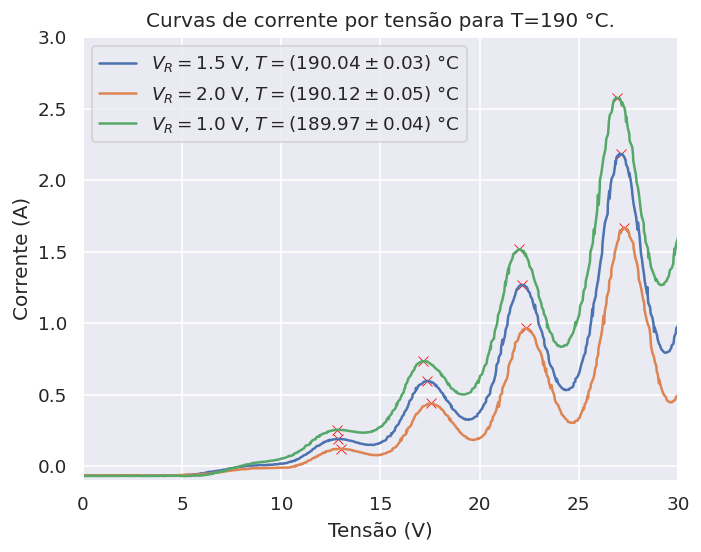

In [254]:
T = 190
plt.title(f'Curvas de corrente por tensão para T={T} °C.')

for i,Vr in enumerate(data[T].keys()):
  df = data[T][Vr]

  Tm, Ts = df["Temperatura (°C)"].mean(), df["Temperatura (°C)"].std() / np.sqrt(df.shape[0])
  sns.lineplot(data=df, x='Tensão (V)', y='Corrente (A)', label=f'$V_R={Vr}$ V, $T=({Tm:.2f}\\pm{Ts:.2f})$ °C')

  _peaks, props = find_peaks(df['Corrente (A)'], distance=40, prominence=(0.004, 5))
  peaks[T][Vr] = np.array(_peaks)

  sns.scatterplot(x=df['Tensão (V)'][_peaks], y=df['Corrente (A)'][_peaks], color='red', marker='x')

plt.ylim(-0.1, 3)
plt.xlim(0, 30)

plt.savefig(f'plots/current_curves_{T}.png', dpi=300, bbox_inches='tight')
plt.show()

In [255]:
df_peaks = {}

for i,T in enumerate(peaks.keys()):
  df_peaks[T] = {}
  for j,Vr in enumerate(peaks[T].keys()):
    df_peaks[T][Vr] = pd.DataFrame({
      'Tensão (V)': data[T][Vr]['Tensão (V)'][ peaks[T][Vr] ],
      'Corrente (A)': data[T][Vr]['Corrente (A)'][ peaks[T][Vr] ]
    })

## Determinação do potencial $V_0$

Estimativa para o valor de $V_0$ a partir das diferenças das tensões dos picos.

In [256]:
deltas = []

for i,T in enumerate(data.keys()):
  for j,Vr in enumerate(data[T].keys()):
    df = data[T][Vr]

    ddp = np.array(df['Tensão (V)'][ peaks[T][Vr] ])
    Dddp = ddp - np.roll(ddp, 1)

    deltas = np.append(deltas, Dddp[1:])

In [257]:
V0, V0s = np.mean(deltas),np.std(deltas) / np.sqrt(len(deltas))
V0, V0s

(4.947619047619048, 0.08075579705651756)

### Ajuste quadrático

In [258]:
def quad(x, a, b): return a * np.power(x, 2) + b
def inQuad(y, a, b): return np.sqrt(np.abs( (y - b) / a ))

In [259]:
fits = {}
square_voltages = {}

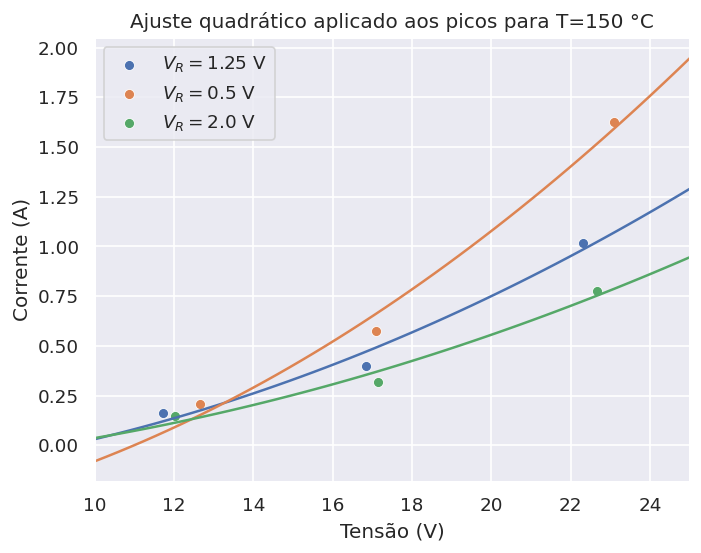

In [260]:
T = 150
fits[T] = {}
square_voltages[T] = {}

plt.title(f'Ajuste quadrático aplicado aos picos para T={T} °C')

for j,Vr in enumerate(df_peaks[T].keys()):
  df = df_peaks[T][Vr]

  popt, pcov = curve_fit(
      quad,
      xdata=df['Tensão (V)'],
      ydata=df['Corrente (A)']
  )

  fits[T][Vr] = popt

  square_voltages[T][Vr] = []
  for k,I in enumerate(df['Corrente (A)']): square_voltages[T][Vr].append(inQuad( I, popt[0], popt[1] ))

  x = np.linspace(10, 25)
  sns.lineplot(x=x, y=quad(x, popt[0], popt[1]))
  sns.scatterplot(x=df['Tensão (V)'], y=df['Corrente (A)'], label=f'$V_R={Vr}$ V')

plt.xlim(10, 25)
plt.savefig(f'plots/square_fit_peaks_{T}.png', dpi=300, bbox_inches='tight')
plt.show()

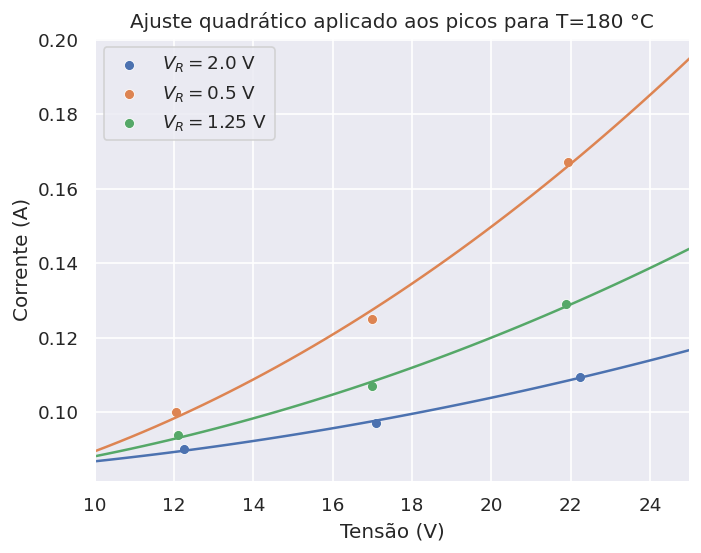

In [261]:
T = 180
fits[T] = {}
square_voltages[T] = {}

plt.title(f'Ajuste quadrático aplicado aos picos para T={T} °C')

for j,Vr in enumerate(df_peaks[T].keys()):
  df = df_peaks[T][Vr]

  popt, pcov = curve_fit(
      quad,
      xdata=df['Tensão (V)'],
      ydata=df['Corrente (A)']
  )

  fits[T][Vr] = popt

  square_voltages[T][Vr] = []
  for k,I in enumerate(df['Corrente (A)']): square_voltages[T][Vr].append(inQuad( I, popt[0], popt[1] ))

  x = np.linspace(10, 25)
  sns.lineplot(x=x, y=quad(x, popt[0], popt[1]))
  sns.scatterplot(x=df['Tensão (V)'], y=df['Corrente (A)'], label=f'$V_R={Vr}$ V')

plt.xlim(10, 25)
plt.savefig(f'plots/square_fit_peaks_{T}.png', dpi=300, bbox_inches='tight')
plt.show()

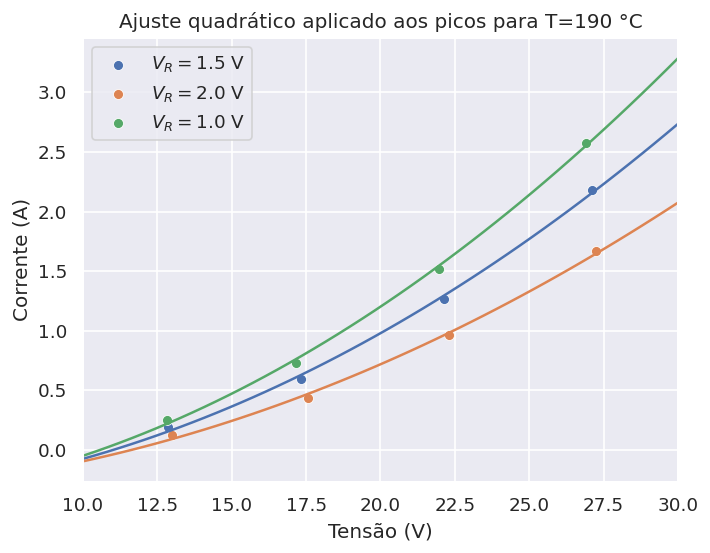

In [262]:
T = 190
fits[T] = {}
square_voltages[T] = {}

plt.title(f'Ajuste quadrático aplicado aos picos para T={T} °C')


for j,Vr in enumerate(df_peaks[T].keys()):
  df = df_peaks[T][Vr]

  popt, pcov = curve_fit(
      quad,
      xdata=df['Tensão (V)'],
      ydata=df['Corrente (A)']
  )

  fits[T][Vr] = popt

  square_voltages[T][Vr] = []
  for k,I in enumerate(df['Corrente (A)']): square_voltages[T][Vr].append(inQuad( I, popt[0], popt[1] ))

  x = np.linspace(10, 30)
  sns.lineplot(x=x, y=quad(x, popt[0], popt[1]))
  sns.scatterplot(x=df['Tensão (V)'], y=df['Corrente (A)'], label=f'$V_R={Vr}$ V')

plt.xlim(10, 30)
plt.savefig(f'plots/square_fit_peaks_{T}.png', dpi=300, bbox_inches='tight')
plt.show()

In [263]:
deltas = []

for i,T in enumerate(square_voltages.keys()):
  for j,Vr in enumerate(square_voltages[T].keys()):
    arr = square_voltages[T][Vr]

    Dddp = arr - np.roll(arr, 1)

    deltas = np.append(deltas, Dddp[1:])

In [264]:
V0, V0s = np.mean(deltas), np.std(deltas) / np.sqrt(len(deltas))
V0, V0s

(4.821124925845659, 0.2318834840228704)